In [1]:
import numpy as np

import skimage.data

import skimage.color
from skimage.filters import laplace
import matplotlib.pyplot as plt


image = skimage.data.astronaut()

image = skimage.color.rgb2gray(image)
image.shape

(512, 512)

In [2]:
def laplace_skimage(image):
    laplacian = laplace(image)
    thresh = np.abs(laplacian) > 0.05
    return thresh

In [3]:
edges = laplace_skimage(image)
edges.shape

(512, 512)

In [4]:
def compare(left, right):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(left, cmap='gray')
    ax[1].imshow(right, cmap='gray')
    

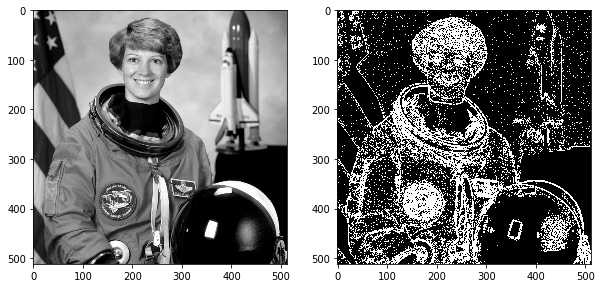

In [5]:
compare(image, edges)

In [6]:
def laplace_numpy(image):
    laplacian = image[:-2, 1:-1] + image[2:, 1:-1] + image[1:-1, :-2] + image[1:-1, 2:] - 4*image[1:-1, 1:-1]
    thresh = np.abs(laplacian) > 0.05
    return thresh

In [7]:
laplace_numpy(image).shape

(510, 510)

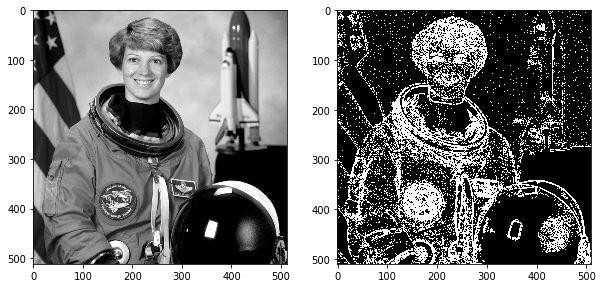

In [8]:
compare(image, laplace_numpy(image))

In [9]:
np.allclose(laplace_skimage(image)[1:-1, 1:-1], laplace_numpy(image))

True

In [10]:
%time laplace_numpy(image)

Wall time: 10 ms


array([[False,  True,  True, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [ True,  True, False, ..., False, False, False],
       ...,
       [False, False, False, ...,  True, False, False],
       [False, False, False, ...,  True, False, False],
       [False, False, False, ...,  True,  True, False]])

In [14]:
%timeit laplace_numpy(image)


100 loops, best of 3: 5.48 ms per loop


In [15]:
%timeit laplace_skimage(image)

100 loops, best of 3: 3.38 ms per loop


In [16]:
from numba import jit


@jit
def laplace_numba(image):
    laplacian = image[:-2, 1:-1] + image[2:, 1:-1] + image[1:-1, :-2] + image[1:-1, 2:] - 4 * image[1:-1, 1:-1]
    thresh = np.abs(laplacian) > 0.05
    return thresh

In [17]:
laplace_numba(image)

%timeit laplace_numba(image)

100 loops, best of 3: 2.03 ms per loop


In [18]:
@jit(nopython=True)
def laplace_numba(image):
    h = image.shape[0]
    w = image.shape[1]
    laplacian = np.empty((h-2, w-2))
    for i in range(1, h-1):
        for j in range(1, w-1):
            laplacian[i-1, j-1] = np.abs(image[i-1, j] + image[i+1, j] + image[i, j+1] + image[i, j-1] - 4 * image[i, j])
    return laplacian


In [19]:
laplace_numba(image);
%timeit laplace_numba(image)

1000 loops, best of 3: 818 µs per loop


In [20]:
from numba import guvectorize


@guvectorize('void(float64[:, :], float64[:, :])', "(m, n)->(m, n)")
def laplace_numba_guvectorize(image, laplacian):
    h = image.shape[0]
    w = image.shape[1]
    for i in range(1, h-1):
        for j in range(1, w-1):
            laplacian[i-1, j-1] = np.abs(4 * image[i, j] - image[i - 1, j] - image[i + 1, j] - image[i, j + 1] - image[i, j - 1]) > 0.05
    

In [21]:
laplacian = np.empty_like(image)
laplace_numba_guvectorize(image, laplacian);
np.allclose(laplace_numpy(image), laplacian[:-2, :-2])


True

In [22]:
%timeit laplace_numba_guvectorize(image, laplacian)

1000 loops, best of 3: 458 µs per loop


In [64]:
@guvectorize('void(float64[:, :], float64[:, :])', "(m, n)->(m, n)", target='parallel', nopython=True)
def laplace_numba_guvectorize_paralel(image, laplacian):
    h = image.shape[0]
    w = image.shape[1]
    for i in range(1, h-1):
        for j in range(1, w-1):
            laplacian[i-1, j-1] = (4 * image[i, j] - image[i - 1, j] - image[i + 1, j] - image[i, j + 1] - image[i, j - 1]) > 0.05
            if laplacian[i-1, j-1] < 0:
                laplacian[i-1, j-1] = -laplacian[i-1, j-1]
    


In [65]:
%timeit laplace_numba_guvectorize_paralel(image, laplacian)


1000 loops, best of 3: 468 µs per loop


In [66]:
import os


os.environ['NUMBAPRO_NVVM'] = r'C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v8.0\nvvm\bin\nvvm64_31_0.dll'

os.environ['NUMBAPRO_LIBDEVICE'] = r'C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v8.0\nvvm\libdevice'


In [67]:
@guvectorize('void(float64[:, :], float64[:, :])', "(m, n)->(m, n)", target='cuda', nopython=True)
def laplace_numba_gpu(image, laplacian):
    h = image.shape[0]
    w = image.shape[1]
    for i in range(1, h-1):
        for j in range(1, w-1):
            laplacian[i-1, j-1] = (4 * image[i, j] - image[i - 1, j] - image[i + 1, j] - image[i, j + 1] - image[i, j - 1]) > 0.05
            if laplacian[i-1, j-1] < 0:
                laplacian[i-1, j-1] = -laplacian[i-1, j-1]
    

In [69]:
%timeit laplace_numba_gpu(image, laplacian)

# Note: This operation is too simple, so its faster to just paralelize on the CPU rather than transfer the bytes to the GPU and back

10 loops, best of 3: 161 ms per loop


In [93]:

funcs = [laplace_skimage, laplace_numpy, laplace_numba, laplace_numba_guvectorize, laplace_numba_guvectorize_paralel, laplace_numba_gpu]
names = ["laplace_skimage", "laplace_numpy", "laplace_numba", "laplace_numba_guvectorize", "laplace_numba_guvectorize_paralel", "laplace_numba_gpu"]
timings = {}
i = 0
for func in funcs:
    t = %timeit -o func(image)
    timings[names[i]] = t
    i += 1


{'laplace_numba': <TimeitResult : 1000 loops, best of 3: 776 µs per loop>,
 'laplace_numba_gpu': <TimeitResult : 10 loops, best of 3: 162 ms per loop>,
 'laplace_numba_guvectorize': <TimeitResult : 1000 loops, best of 3: 1.02 ms per loop>,
 'laplace_numba_guvectorize_paralel': <TimeitResult : 1000 loops, best of 3: 1.07 ms per loop>,
 'laplace_numpy': <TimeitResult : 100 loops, best of 3: 6.27 ms per loop>,
 'laplace_skimage': <TimeitResult : 100 loops, best of 3: 3.82 ms per loop>}

In [94]:
names

{'laplace_numba': <TimeitResult : 1000 loops, best of 3: 776 µs per loop>,
 'laplace_numba_gpu': <TimeitResult : 10 loops, best of 3: 162 ms per loop>,
 'laplace_numba_guvectorize': <TimeitResult : 1000 loops, best of 3: 1.02 ms per loop>,
 'laplace_numba_guvectorize_paralel': <TimeitResult : 1000 loops, best of 3: 1.07 ms per loop>,
 'laplace_numpy': <TimeitResult : 100 loops, best of 3: 6.27 ms per loop>,
 'laplace_skimage': <TimeitResult : 100 loops, best of 3: 3.82 ms per loop>}

In [95]:
timings


{'laplace_numba': <TimeitResult : 1000 loops, best of 3: 776 µs per loop>,
 'laplace_numba_gpu': <TimeitResult : 10 loops, best of 3: 162 ms per loop>,
 'laplace_numba_guvectorize': <TimeitResult : 1000 loops, best of 3: 1.02 ms per loop>,
 'laplace_numba_guvectorize_paralel': <TimeitResult : 1000 loops, best of 3: 1.07 ms per loop>,
 'laplace_numpy': <TimeitResult : 100 loops, best of 3: 6.27 ms per loop>,
 'laplace_skimage': <TimeitResult : 100 loops, best of 3: 3.82 ms per loop>}

In [97]:
import pandas as pd


pd.Series({key: round(timings[key].best * 1e6, 2) for key in timings}).to_frame(name='timings (μs)').sort_values(by='timings (μs)')

,timings (μs)
laplace_numba,776.14
laplace_numba_guvectorize,1022.53
laplace_numba_guvectorize_paralel,1066.06
laplace_skimage,3815.86
laplace_numpy,6272.77
laplace_numba_gpu,162272.58


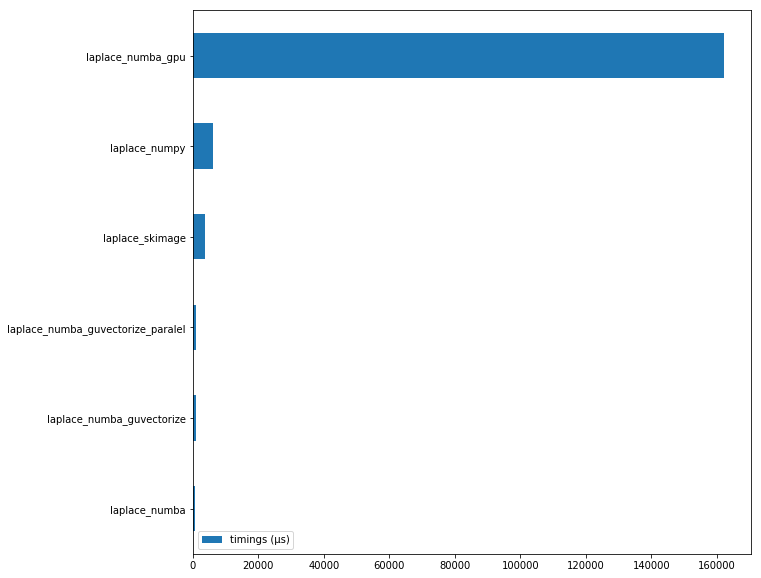

In [103]:
fig, ax = plt.subplots(figsize=(10, 10))

pd.Series({key: round(timings[key].best * 1e6, 2) for key in timings}).to_frame(name='timings (μs)').sort_values(by='timings (μs)').plot(kind='barh', ax=ax)

In [ ]:
# and now without the outlier GPU 
del timings['laplace_numba_gpu']

fig, ax = plt.subplots(figsize=(10, 10))

pd.Series({key: round(timings[key].best * 1e6, 2) for key in timings}).to_frame(name='timings (μs)').sort_values(by='timings (μs)').plot(kind='barh', ax=ax)

